   influencer_id          name  followers  engagement_rate platform
0              1   Emma Miller     131734             7.54   TikTok
1              2  Oliver Starr    9529966             3.77  YouTube
2              3    Anna Smith    3019975             5.65   TikTok
3              4     Sarah Doe    5918229             4.17  Twitter
4              5   Anna Taylor    3135310             5.15  Twitter
   post_id  user_id                                            content  likes  \
0        1     2137  Trying out new recipes and loving the results!...  71454   
1        2     4337  Just finished a 5K! Can't wait for the next on...  28692   
2        3     4716  Traveling soon! Any recommendations for amazin...  66460   
3        4     1294  Just finished a 5K! Can't wait for the next on...  67406   
4        5     3693  Traveling soon! Any recommendations for amazin...  42185   

   shares  comments            timestamp platform    category  
0    2486       721  2024-02-18 14:50:48 

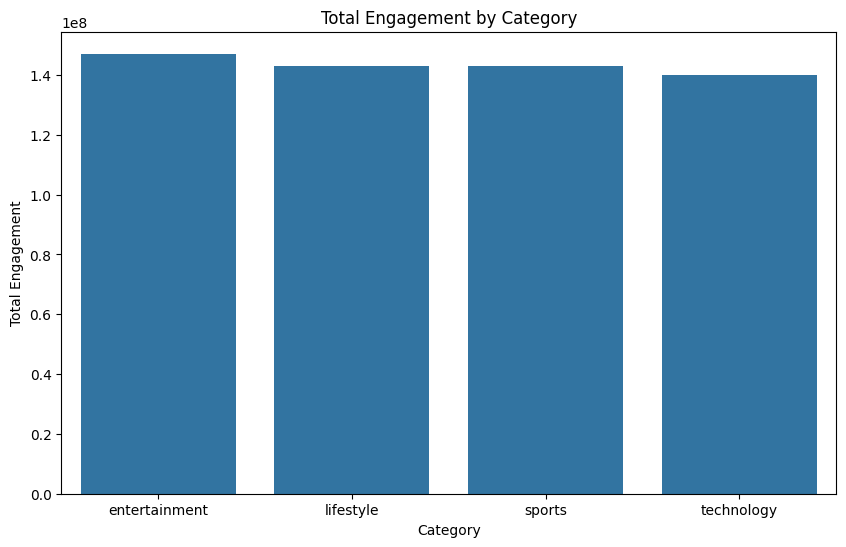

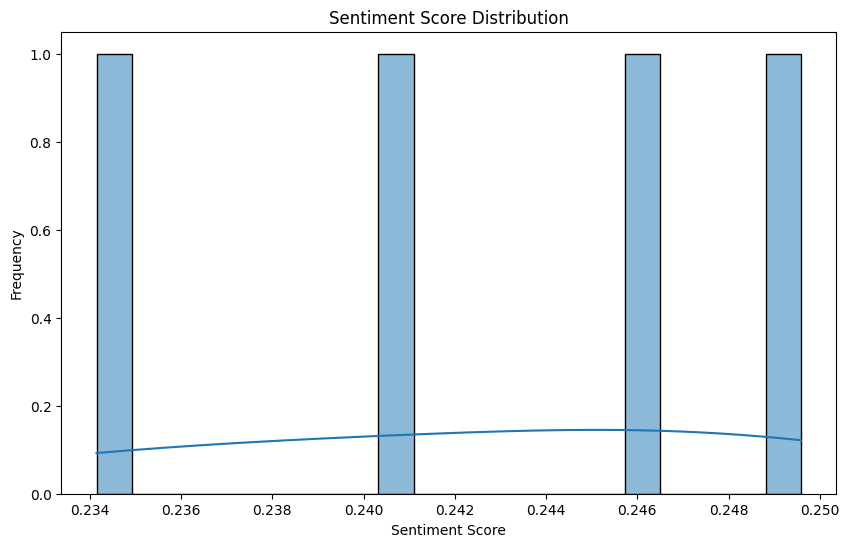


Engagement Prediction Model Performance:
Mean Squared Error: 848289681.0134695
R-squared: -0.0010777112304340974

Top-performing Influencers by Category:
        category  total_engagement  average_sentiment  total_followers
0  entertainment         147093840           0.249587      12913544857
1      lifestyle         143052483           0.234148      12789734832
2         sports         142831596           0.240447      12368037557
3     technology         140075111           0.246297      12118751195

'platform' column is missing in the data. Please check the dataset.

Top Hashtags by Frequency:
          hashtag  count
0        #fitness   4034
1  #entertainment   3109
2           #tech   2951
3         #movies   2034
4         #future   2030

Post Activity Over Time:
           date  post_count
0    2024-01-01          26
1    2024-01-02          26
2    2024-01-03          45
3    2024-01-04          30
4    2024-01-05          37
..          ...         ...
309  2024-11-05      

In [13]:
import pandas as pd
import json
from textblob import TextBlob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import plotly.express as px

# Setup Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def log_error(error_message):
    logging.error(error_message)

# Load influencers data (CSV file)
def load_influencers(file_path):
    return pd.read_csv(file_path)

# Load posts data (JSON file)
def load_posts(file_path):
    with open(file_path, 'r') as f:
        return pd.json_normalize(json.load(f))

# Load post text data (Text file)
def load_text_data(file_path):
    with open(file_path, 'r') as f:
        return pd.DataFrame({'text': f.readlines()})

# Example usage of file paths
csv_path = r"C:\Users\abhishek\data\influencers.csv"
json_path = r"C:\Users\abhishek\data\social_media_posts_meaningful.json"
txt_path = r"C:\Users\abhishek\data\generated_text_data.txt"

# Loading the data using the functions
influencers_df = load_influencers(csv_path)
posts_df = load_posts(json_path)
text_data_df = load_text_data(txt_path)

# Check the data
print(influencers_df.head())  # Influencer data
print(posts_df.head())        # Posts data
print(text_data_df.head())    # Text data

# Sentiment analysis function
def map_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment mapping to text data
text_data_df['sentiment_score'] = text_data_df['text'].apply(map_sentiment)
print("\nText Data with Sentiment Scores:")
print(text_data_df.head())

# Calculate total engagement for each post
posts_df['total_engagement'] = posts_df['likes'] + posts_df['comments'] + posts_df['shares']

# Aggregation by category
def reduce_aggregate(df, group_by_col, agg_dict):
    return df.groupby(group_by_col).agg(agg_dict).reset_index()

agg_result = reduce_aggregate(posts_df, 'category', {'total_engagement': 'sum'})
print("\nAggregated Engagement by Category:")
print(agg_result)

# Sentiment analysis for posts (Assuming text_data_df corresponds to posts_df)
posts_df['sentiment_score'] = text_data_df['sentiment_score']

# Calculate engagement and sentiment by category
def calculate_engagement(df):
    return df.groupby('category').agg(
        total_engagement=('total_engagement', 'sum'),
        average_sentiment=('sentiment_score', 'mean')
    ).reset_index()

final_result = calculate_engagement(posts_df)
print("\nFinal Engagement and Sentiment Analysis by Category:")
print(final_result)

# Save final results to CSV
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
final_output_path = os.path.join(output_dir, "final_aggregated_results.csv")
final_result.to_csv(final_output_path, index=False)
print(f"\nFinal Aggregated Results Saved to {final_output_path}")

# Batch processing for large datasets
def process_batch(df, batch_size):
    for start in range(0, len(df), batch_size):
        yield df[start:start + batch_size]

batch_size = 2
batch_results = []
batch_dir = "../output/batch_results/"
os.makedirs(batch_dir, exist_ok=True)  # Create the batch results directory

for i, batch in enumerate(process_batch(posts_df, batch_size)):
    batch_file = os.path.join(batch_dir, f'batch_{i+1}.csv')
    batch_results.append(batch)
    batch.to_csv(batch_file, index=False)
    print(f"Saving batch {i+1} to {batch_file}")

# Visualization of engagement and sentiment
def plot_engagement_by_category(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='category', y='total_engagement', data=df)
    plt.title("Total Engagement by Category")
    plt.xlabel('Category')
    plt.ylabel('Total Engagement')
    plt.show()

def plot_sentiment_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['average_sentiment'], bins=20, kde=True)
    plt.title("Sentiment Score Distribution")
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

# Plot engagement and sentiment
plot_engagement_by_category(final_result)
plot_sentiment_distribution(final_result)

# Visualization using Plotly
def visualize_data(df):
    fig = px.bar(df, x='category', y='total_engagement', color='category',
                 title="Total Engagement by Category", labels={"category": "Category", "total_engagement": "Total Engagement"})
    fig.show()

# Merging influencer data with posts data
posts_df['influencer_id'] = posts_df['user_id']  # Mapping user_id to influencer_id
df = pd.merge(posts_df, influencers_df, how='left', on='influencer_id')
df.fillna(0, inplace=True)  # Handle missing values

# Engagement Prediction: Linear Regression Model
X = df[['followers', 'sentiment_score']]  # Features (followers and sentiment)
y = df['total_engagement']  # Target variable (engagement)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluating model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEngagement Prediction Model Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Top-performing Influencers by Category
top_influencers_by_category = df.groupby('category').agg(
    total_engagement=('total_engagement', 'sum'),
    average_sentiment=('sentiment_score', 'mean'),
    total_followers=('followers', 'sum')
).reset_index()

print("\nTop-performing Influencers by Category:")
print(top_influencers_by_category)

# Platform-wise Sentiment Analysis
# Check if 'platform' column exists before performing the analysis
if 'platform' in df.columns:
    platform_sentiment = df.groupby('platform').agg(
        average_sentiment=('sentiment_score', 'mean'),
        total_engagement=('total_engagement', 'sum')
    ).reset_index()

    print("\nPlatform-wise Sentiment Analysis:")
    print(platform_sentiment)
else:
    print("\n'platform' column is missing in the data. Please check the dataset.")

# Hashtag Analysis
def extract_hashtags(text):
    return [word for word in text.split() if word.startswith('#')]

# Apply hashtag extraction to 'content' column instead of 'text'
posts_df['hashtags'] = posts_df['content'].apply(extract_hashtags)
hashtag_counts = posts_df['hashtags'].explode().value_counts().reset_index()
hashtag_counts.columns = ['hashtag', 'count']

print("\nTop Hashtags by Frequency:")
print(hashtag_counts.head())

# Post Activity Over Time
posts_df['post_date'] = pd.to_datetime(posts_df['timestamp'])
posts_df['date'] = posts_df['post_date'].dt.date
post_activity_over_time = posts_df.groupby('date').size().reset_index(name='post_count')

print("\nPost Activity Over Time:")
print(post_activity_over_time)

# Save Results
engagement_prediction_path = os.path.join(output_dir, "predicted_engagement.csv")

# Add predicted engagement to the DataFrame
df['predicted_engagement'] = model.predict(X)

# Save the DataFrame with the predicted engagement column
df.to_csv(engagement_prediction_path, index=False)
print(f"\nEngagement Prediction Results Saved to {engagement_prediction_path}")

# Save the top-performing influencers by category
top_influencers_path = os.path.join(output_dir, "top_influencers_by_category.csv")
top_influencers_by_category.to_csv(top_influencers_path, index=False)
print(f"Top Performing Influencers Saved to {top_influencers_path}")

# Save platform sentiment analysis if available
platform_sentiment_path = os.path.join(output_dir, "platform_sentiment_analysis.csv")
if 'platform' in df.columns:
    platform_sentiment.to_csv(platform_sentiment_path, index=False)
    print(f"Platform-wise Sentiment Analysis Saved to {platform_sentiment_path}")
else:
    print("No platform sentiment analysis was saved due to missing 'platform' column.")

# Save hashtag counts
hashtag_counts_path = os.path.join(output_dir, "hashtag_counts.csv")
hashtag_counts.to_csv(hashtag_counts_path, index=False)
print(f"Hashtag Counts Saved to {hashtag_counts_path}")


